# Imports

In [5]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchmetrics

try:
    from torchmetrics.image.fid import FrechetInceptionDistance
except ImportError:
    FrechetInceptionDistance = None
    print("torchmetrics not installed, FID computation will be skipped.")

In [3]:
import sys
print(sys.executable)

!{sys.executable} -m pip install torch-fidelity torchmetrics[image]

try:
    import torch_fidelity
    print("torch_fidelity import OK")
except ImportError as e:
    print("torch_fidelity import FAILED:", e)


/home/blozerx/venvs/smai-env/bin/python
torch_fidelity import OK


# VAE

Training VAE with beta=0.1
Epoch 01 beta=0.1: train_total=282.0718, val_total=264.1023
Epoch 02 beta=0.1: train_total=260.2833, val_total=259.4436
Epoch 03 beta=0.1: train_total=256.7812, val_total=256.7272
Epoch 04 beta=0.1: train_total=254.7851, val_total=255.6867
Epoch 05 beta=0.1: train_total=253.6809, val_total=254.5428
Epoch 06 beta=0.1: train_total=252.8328, val_total=253.9347
Epoch 07 beta=0.1: train_total=251.8998, val_total=253.7800
Epoch 08 beta=0.1: train_total=251.3503, val_total=253.1010
Epoch 09 beta=0.1: train_total=250.7590, val_total=252.2158
Epoch 10 beta=0.1: train_total=250.4817, val_total=251.8815
Epoch 11 beta=0.1: train_total=250.0071, val_total=251.9108
Epoch 12 beta=0.1: train_total=249.5132, val_total=251.0375
Epoch 13 beta=0.1: train_total=249.2246, val_total=251.2218
Epoch 14 beta=0.1: train_total=248.7785, val_total=250.8130
Epoch 15 beta=0.1: train_total=248.5385, val_total=251.8581


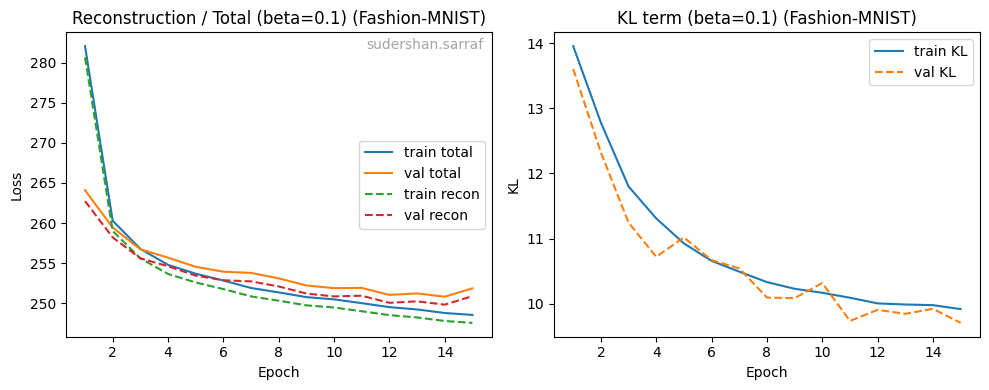

Training VAE with beta=0.5
Epoch 01 beta=0.5: train_total=285.2177, val_total=268.1774
Epoch 02 beta=0.5: train_total=263.8047, val_total=262.7927
Epoch 03 beta=0.5: train_total=260.6833, val_total=260.9245
Epoch 04 beta=0.5: train_total=258.7249, val_total=259.3237
Epoch 05 beta=0.5: train_total=257.4471, val_total=258.3791
Epoch 06 beta=0.5: train_total=256.5263, val_total=257.4281
Epoch 07 beta=0.5: train_total=256.0300, val_total=257.5222
Epoch 08 beta=0.5: train_total=255.2024, val_total=256.3392
Epoch 09 beta=0.5: train_total=254.6836, val_total=256.1038
Epoch 10 beta=0.5: train_total=254.1251, val_total=256.6384
Epoch 11 beta=0.5: train_total=253.7165, val_total=255.0086
Epoch 12 beta=0.5: train_total=253.1686, val_total=255.2249
Epoch 13 beta=0.5: train_total=252.8903, val_total=254.4454
Epoch 14 beta=0.5: train_total=252.4185, val_total=254.5413
Epoch 15 beta=0.5: train_total=252.2496, val_total=253.8420


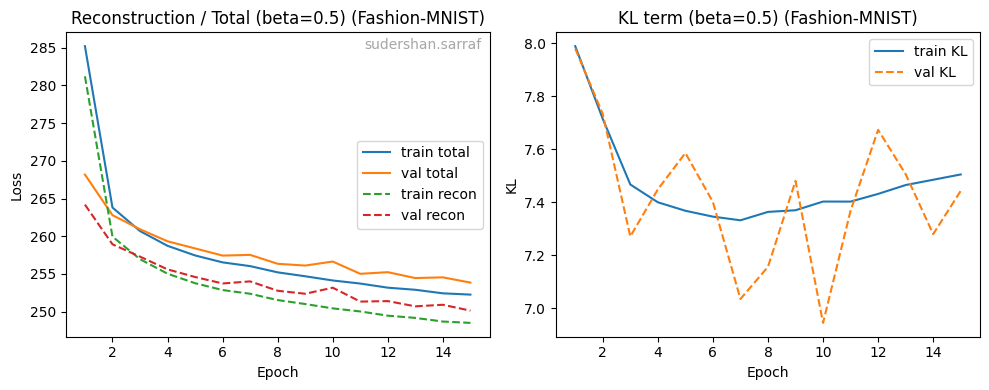

Training VAE with beta=1.0
Epoch 01 beta=1.0: train_total=288.8782, val_total=271.1263
Epoch 02 beta=1.0: train_total=267.1497, val_total=266.2605
Epoch 03 beta=1.0: train_total=263.8932, val_total=265.2400
Epoch 04 beta=1.0: train_total=262.1059, val_total=263.1459
Epoch 05 beta=1.0: train_total=260.8677, val_total=261.9087
Epoch 06 beta=1.0: train_total=259.9098, val_total=261.4297
Epoch 07 beta=1.0: train_total=259.2475, val_total=260.2338
Epoch 08 beta=1.0: train_total=258.7301, val_total=260.0919
Epoch 09 beta=1.0: train_total=258.2105, val_total=259.4179
Epoch 10 beta=1.0: train_total=257.5919, val_total=259.4698
Epoch 11 beta=1.0: train_total=257.3524, val_total=259.0390
Epoch 12 beta=1.0: train_total=257.1575, val_total=259.6473
Epoch 13 beta=1.0: train_total=256.6229, val_total=258.5939
Epoch 14 beta=1.0: train_total=256.5256, val_total=258.0436
Epoch 15 beta=1.0: train_total=256.0362, val_total=257.6259


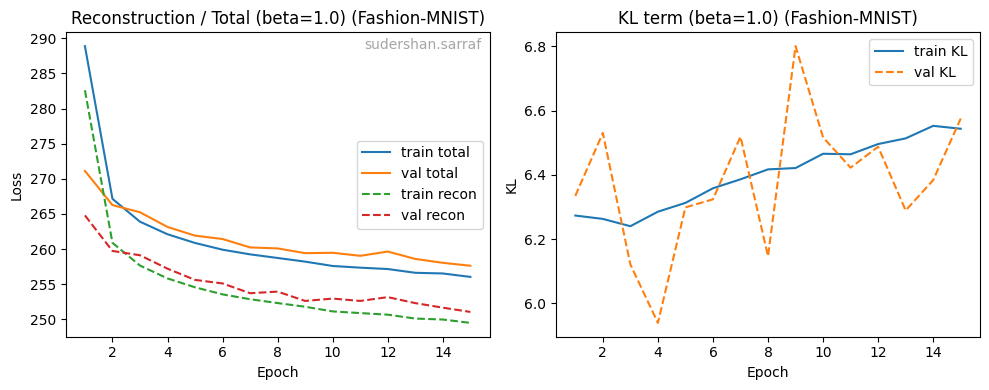

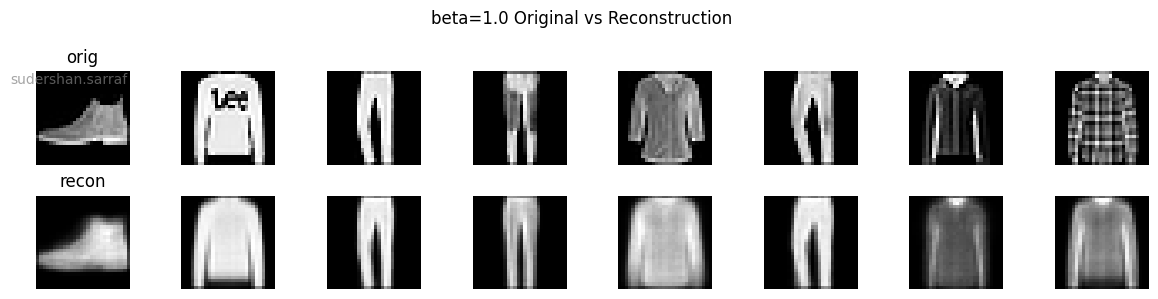

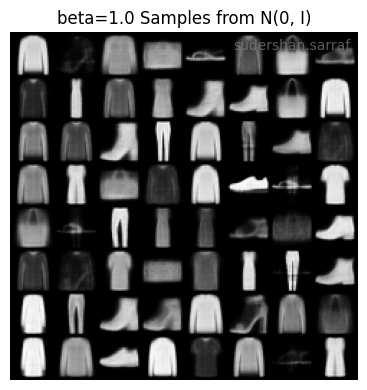

FID (approximate, feature=2048, 79 batches): 109.3288


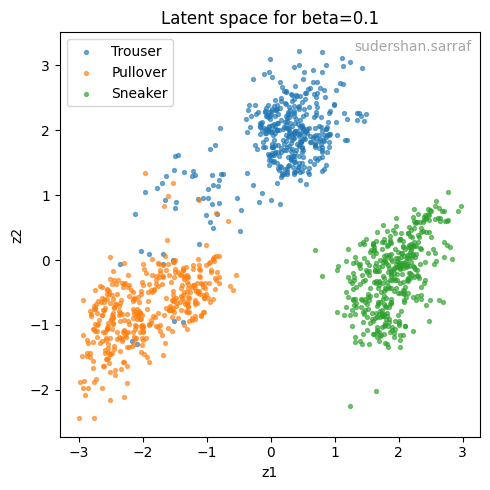

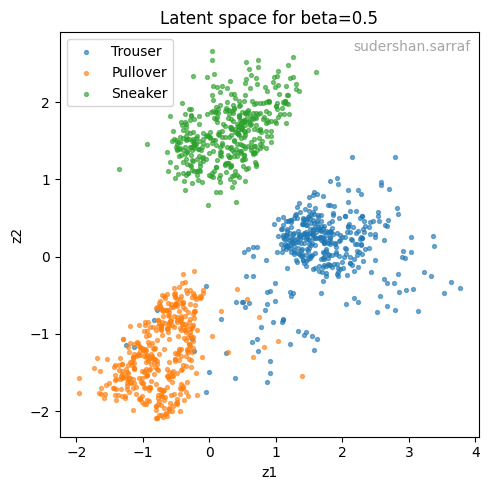

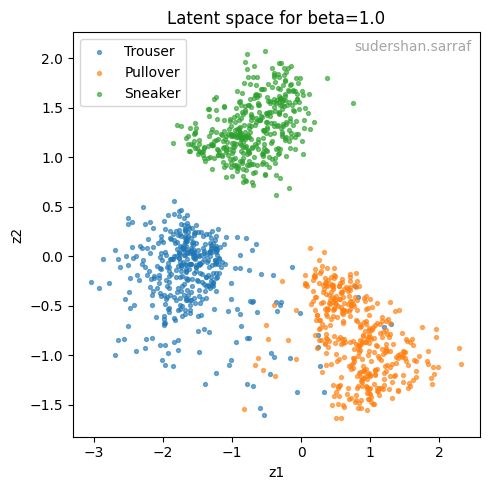

[video-train] Epoch 01 beta=1.0: train_total=290.5423
[video-train] Epoch 02 beta=1.0: train_total=268.1593
Saved latent evolution training video to data/4/latent_evolution_training_beta1.mp4


In [10]:
# FID
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
except ImportError:
    FrechetInceptionDistance = None
    print("torchmetrics.image not available; FID will be skipped.")

# Username helpers
if "EMAIL_USERNAME" not in globals():
    EMAIL_USERNAME = "sudershan.sarraf"

if "add_username_to_plot" not in globals():
    def add_username_to_plot(ax, username):
        ax.text(
            0.98, 0.98,
            username,
            ha="right", va="top",
            transform=ax.transAxes,
            fontsize=10, color="gray", alpha=0.7
        )

def maybe_add_username(ax):
    if "EMAIL_USERNAME" in globals() and "add_username_to_plot" in globals():
        add_username_to_plot(ax, EMAIL_USERNAME)

# Globals
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_ROOT_Q4 = "data/4"
BATCH_SIZE_Q4 = 128

CLASS_NAMES_Q4 = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Data
def get_fashion_mnist_dataloaders(batch_size=BATCH_SIZE_Q4):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_ds = datasets.FashionMNIST(
        root=DATA_ROOT_Q4,
        train=True,
        download=True,
        transform=transform
    )
    test_ds = datasets.FashionMNIST(
        root=DATA_ROOT_Q4,
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, train_ds, test_ds

# VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_hat = self.decoder_fc(z)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z

# Loss & standard training
def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)

    recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum") / x.size(0)

    kl = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    ) / x.size(0)

    total = recon_loss + beta * kl
    return total, recon_loss.detach(), kl.detach()

def train_vae(model, train_loader, val_loader,
              beta=1.0, epochs=20, lr=1e-3, device=DEVICE):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_total": [], "train_recon": [], "train_kl": [],
        "val_total": [], "val_recon": [], "val_kl": []
    }

    for epoch in range(epochs):
        model.train()
        train_total = 0.0
        train_recon = 0.0
        train_kl = 0.0
        n_train = 0

        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar, z = model(x)
            total, recon, kl = vae_loss(x, x_hat, mu, logvar, beta=beta)
            total.backward()
            optimizer.step()

            bs = x.size(0)
            n_train += bs
            train_total += total.item() * bs
            train_recon += recon.item() * bs
            train_kl += kl.item() * bs

        history["train_total"].append(train_total / n_train)
        history["train_recon"].append(train_recon / n_train)
        history["train_kl"].append(train_kl / n_train)

        model.eval()
        val_total = 0.0
        val_recon = 0.0
        val_kl = 0.0
        n_val = 0

        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_hat, mu, logvar, z = model(x)
                total, recon, kl = vae_loss(x, x_hat, mu, logvar, beta=beta)

                bs = x.size(0)
                n_val += bs
                val_total += total.item() * bs
                val_recon += recon.item() * bs
                val_kl += kl.item() * bs

        history["val_total"].append(val_total / n_val)
        history["val_recon"].append(val_recon / n_val)
        history["val_kl"].append(val_kl / n_val)

        print(
            f"Epoch {epoch+1:02d} beta={beta}: "
            f"train_total={history['train_total'][-1]:.4f}, "
            f"val_total={history['val_total'][-1]:.4f}"
        )

    return history

# Plots & samples
def plot_vae_loss(history, beta, title_suffix=""):
    epochs = np.arange(1, len(history["train_total"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    ax.plot(epochs, history["train_total"], label="train total")
    ax.plot(epochs, history["val_total"], label="val total")
    ax.plot(epochs, history["train_recon"], label="train recon", linestyle="--")
    ax.plot(epochs, history["val_recon"], label="val recon", linestyle="--")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"Reconstruction / Total (beta={beta}) {title_suffix}")
    ax.legend()

    ax2 = axes[1]
    ax2.plot(epochs, history["train_kl"], label="train KL")
    ax2.plot(epochs, history["val_kl"], label="val KL", linestyle="--")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("KL")
    ax2.set_title(f"KL term (beta={beta}) {title_suffix}")
    ax2.legend()

    add_username_to_plot(axes[0], EMAIL_USERNAME)
    plt.tight_layout()
    plt.show()

def show_reconstructions(model, data_loader, device=DEVICE,
                         num_images=8, title_prefix=""):
    model.eval()
    imgs, _ = next(iter(data_loader))
    imgs = imgs[:num_images].to(device)
    with torch.no_grad():
        x_hat, mu, logvar, z = model(imgs)

    imgs = imgs.cpu()
    x_hat = x_hat.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 1.5, 3))
    for i in range(num_images):
        axes[0, i].imshow(imgs[i, 0], cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title("orig" if i == 0 else "")

        axes[1, i].imshow(x_hat[i, 0], cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title("recon" if i == 0 else "")

    add_username_to_plot(axes[0, 0], EMAIL_USERNAME)
    fig.suptitle(f"{title_prefix}Original vs Reconstruction")
    plt.tight_layout()
    plt.show()

def sample_from_prior(model, num_samples=64, device=DEVICE, title_prefix=""):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim, device=device)
        samples = model.decode(z).cpu()

    from torchvision.utils import make_grid
    grid = make_grid(samples, nrow=int(math.sqrt(num_samples)), padding=2)
    img = grid[0].numpy()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"{title_prefix}Samples from N(0, I)")
    add_username_to_plot(ax, EMAIL_USERNAME)
    plt.tight_layout()
    plt.show()

# Latent space utilities
def collect_latent_2d(model, data_loader, classes, max_per_class=300, device=DEVICE):
    model.eval()
    zs = []
    ys = []
    counts = {c: 0 for c in classes}

    with torch.no_grad():
        for x, y in data_loader:
            mask = torch.zeros_like(y, dtype=torch.bool)
            for c in classes:
                mask |= (y == c)
            x = x[mask]
            y = y[mask]
            if x.size(0) == 0:
                continue

            x = x.to(device)
            mu, logvar = model.encode(x)
            z = mu.cpu().numpy()
            y_np = y.cpu().numpy()

            for c in classes:
                c_mask = (y_np == c)
                if not np.any(c_mask):
                    continue
                needed = max_per_class - counts[c]
                if needed <= 0:
                    continue
                take_idx = np.where(c_mask)[0][:needed]
                zs.append(z[take_idx])
                ys.append(y_np[take_idx])
                counts[c] += len(take_idx)

            if all(counts[c] >= max_per_class for c in classes):
                break

    if len(zs) == 0:
        return np.zeros((0, 2)), np.zeros((0,), dtype=int)

    zs = np.concatenate(zs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return zs, ys

def plot_latent_space(models_by_beta, data_loader,
                      classes=(0, 3, 5), max_per_class=300):
    for beta, model in models_by_beta.items():
        zs, ys = collect_latent_2d(
            model, data_loader, classes=list(classes),
            max_per_class=max_per_class
        )
        fig, ax = plt.subplots(figsize=(5, 5))
        for c in classes:
            mask = (ys == c)
            ax.scatter(
                zs[mask, 0],
                zs[mask, 1],
                s=8,
                alpha=0.6,
                label=CLASS_NAMES_Q4.get(c, str(c))
            )

        ax.set_xlabel("z1")
        ax.set_ylabel("z2")
        ax.set_title(f"Latent space for beta={beta}")
        ax.legend()
        add_username_to_plot(ax, EMAIL_USERNAME)
        plt.tight_layout()
        plt.show()

# FID
def compute_fid_for_vae(model, real_loader, device=DEVICE, max_batches=50):
    if FrechetInceptionDistance is None:
        print("FID skipped because torchmetrics.image is not available.")
        return None

    try:
        fid = FrechetInceptionDistance(feature=2048, normalize=False).to(device)
    except ModuleNotFoundError as e:
        print("FID skipped because torch-fidelity is not available.")
        print("Details:", e)
        return None
    except Exception as e:
        print("FID skipped due to error initializing FrechetInceptionDistance.")
        print("Details:", e)
        return None

    model.eval()
    num_batches = 0

    with torch.no_grad():
        for x, _ in real_loader:
            x = x.to(device)
            bs = x.size(0)

            real = x.repeat(1, 3, 1, 1)
            real = (real * 255.0).clamp(0, 255).to(torch.uint8)
            fid.update(real, real=True)

            z = torch.randn(bs, model.latent_dim, device=device)
            fake = model.decode(z)
            fake = fake.repeat(1, 3, 1, 1)
            fake = (fake * 255.0).clamp(0, 255).to(torch.uint8)
            fid.update(fake, real=False)

            num_batches += 1
            if num_batches >= max_batches:
                break

    fid_value = float(fid.compute())
    print(f"FID (approximate, feature=2048, {num_batches} batches): {fid_value:.4f}")
    return fid_value

# Latent evolution video helpers
def collect_latent_for_video(
    model,
    data_loader,
    classes=(1,2, 7),
    max_bg_per_class=300,
    max_img_per_class=12,
    device=DEVICE,
):
    """
    For the current model, collect:
      - background latent points (zs_bg, ys_bg) for scatter
      - a small set of (z,img) pairs (zs_img, imgs) to draw thumbnails.
    """
    model.eval()

    zs_bg, ys_bg = [], []
    zs_img, imgs = [], []

    counts_bg = {c: 0 for c in classes}
    counts_img = {c: 0 for c in classes}

    with torch.no_grad():
        for x, y in data_loader:
            mask = torch.zeros_like(y, dtype=torch.bool)
            for c in classes:
                mask |= (y == c)
            x = x[mask]
            y = y[mask]
            if x.size(0) == 0:
                continue

            x = x.to(device)
            mu, logvar = model.encode(x)
            z = mu.cpu().numpy()
            imgs_batch = x.cpu().numpy()
            y_np = y.cpu().numpy()

            for i, c in enumerate(y_np):
                if counts_bg[c] < max_bg_per_class:
                    zs_bg.append(z[i])
                    ys_bg.append(c)
                    counts_bg[c] += 1

                if counts_img[c] < max_img_per_class:
                    zs_img.append(z[i])
                    imgs.append(imgs_batch[i, 0])
                    counts_img[c] += 1

            if all(counts_bg[c] >= max_bg_per_class for c in classes) and \
               all(counts_img[c] >= max_img_per_class for c in classes):
                break

    if len(zs_bg) == 0:
        return (
            np.zeros((0, 2), dtype=np.float32),
            np.zeros((0,), dtype=int),
            np.zeros((0, 2), dtype=np.float32),
            np.zeros((0, 28, 28), dtype=np.float32),
        )

    zs_bg  = np.stack(zs_bg, axis=0)
    ys_bg  = np.array(ys_bg, dtype=int)
    zs_img = np.stack(zs_img, axis=0) if len(zs_img) > 0 else np.zeros((0, 2), dtype=np.float32)
    imgs   = np.stack(imgs,   axis=0) if len(imgs)   > 0 else np.zeros((0, 28, 28), dtype=np.float32)

    return zs_bg, ys_bg, zs_img, imgs

def train_vae_with_latent_video(
    beta,
    train_loader,
    video_data_loader,
    epochs=2,
    lr=1e-3,
    classes=(1,2,7),
    video_path="data/4/latent_evolution_training_beta1.mp4",
    frames_per_epoch=8,
    device=DEVICE,
):
    """
    Train a β-VAE and simultaneously record a latent-space evolution video.

    Each recorded frame shows:
      - latent 2D scatter for 3 classes
      - thumbnails of some images at their latent positions
      - title "3-class | Epoch e/E | Batch b/B"
    """
    model = VAE(latent_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_total": [], "train_recon": [], "train_kl": []
    }

    fig, ax = plt.subplots(figsize=(6, 6))
    writer = animation.FFMpegWriter(fps=10)

    total_batches = len(train_loader)
    batch_stride = max(1, total_batches // frames_per_epoch)

    with writer.saving(fig, video_path, dpi=120):
        for epoch in range(epochs):
            model.train()
            train_total = 0.0
            train_recon = 0.0
            train_kl = 0.0
            n_train = 0

            for batch_idx, (x, _) in enumerate(train_loader):
                x = x.to(device)
                optimizer.zero_grad()
                x_hat, mu, logvar, z = model(x)
                total, recon, kl = vae_loss(x, x_hat, mu, logvar, beta=beta)
                total.backward()
                optimizer.step()

                bs = x.size(0)
                n_train += bs
                train_total += total.item() * bs
                train_recon += recon.item() * bs
                train_kl += kl.item() * bs

                # record a frame every batch_stride batches
                if batch_idx % batch_stride == 0:
                    ax.clear()

                    zs_bg, ys_bg, zs_img, imgs = collect_latent_for_video(
                        model,
                        video_data_loader,
                        classes=classes,
                        max_bg_per_class=300,
                        max_img_per_class=15,
                        device=device,
                    )

                    # background scatter
                    for c in classes:
                        mask = (ys_bg == c)
                        ax.scatter(
                            zs_bg[mask, 0],
                            zs_bg[mask, 1],
                            s=5,
                            alpha=0.3,
                            label=CLASS_NAMES_Q4.get(c, str(c)),
                        )

                    # thumbnails at latent locations
                    for k in range(len(zs_img)):
                        z1, z2 = zs_img[k]
                        img = imgs[k]
                        im = OffsetImage(img, cmap="gray", zoom=0.8)
                        ab = AnnotationBbox(
                            im,
                            (z1, z2),
                            frameon=True,
                            bboxprops=dict(edgecolor="white", linewidth=1),
                        )
                        ax.add_artist(ab)

                    ax.set_xlabel("z1")
                    ax.set_ylabel("z2")
                    ax.set_title(
                        f"3-class | Epoch {epoch+1}/{epochs} | "
                        f"Batch {batch_idx+1}/{total_batches}"
                    )
                    ax.legend(loc="upper left")
                    add_username_to_plot(ax, EMAIL_USERNAME)

                    writer.grab_frame()

            history["train_total"].append(train_total / n_train)
            history["train_recon"].append(train_recon / n_train)
            history["train_kl"].append(train_kl / n_train)

            print(
                f"[video-train] Epoch {epoch+1:02d} beta={beta}: "
                f"train_total={history['train_total'][-1]:.4f}"
            )

    plt.close(fig)
    print(f"Saved latent evolution training video to {video_path}")
    return model, history

# RUN Q4 PIPELINE
train_loader_q4, test_loader_q4, train_ds_q4, test_ds_q4 = get_fashion_mnist_dataloaders()

# 1) β-VAE training for multiple betas
betas = [0.1, 0.5, 1.0]
latent_dim_q4 = 2
epochs_q4 = 15
models_by_beta_q4 = {}
histories_by_beta_q4 = {}

for beta in betas:
    print(f"Training VAE with beta={beta}")
    vae_model = VAE(latent_dim=latent_dim_q4)
    history = train_vae(
        vae_model,
        train_loader_q4,
        test_loader_q4,
        beta=beta,
        epochs=epochs_q4,
        lr=1e-3,
        device=DEVICE
    )
    models_by_beta_q4[beta] = vae_model
    histories_by_beta_q4[beta] = history
    plot_vae_loss(history, beta, title_suffix="(Fashion-MNIST)")

# 2) Choose beta=1.0 as main model
best_beta = 1.0
vae_best = models_by_beta_q4[best_beta]

show_reconstructions(vae_best, test_loader_q4, device=DEVICE,
                     num_images=8, title_prefix=f"beta={best_beta} ")
sample_from_prior(vae_best, num_samples=64, device=DEVICE,
                  title_prefix=f"beta={best_beta} ")

fid_beta_1 = compute_fid_for_vae(
    vae_best, test_loader_q4, device=DEVICE, max_batches=80
)

plot_latent_space(
    models_by_beta_q4,
    test_loader_q4,
    classes=(1,2,7),
    max_per_class=400
)

# 3) Training-time latent evolution video for 3 classes, using epochs & batches
vae_video_model, video_train_history = train_vae_with_latent_video(
    beta=1.0,
    train_loader=train_loader_q4,
    video_data_loader=test_loader_q4,
    epochs=2,   # like the example; adjust if you want
    lr=1e-3,
    classes=(1,2,7),
    video_path="data/4/latent_evolution_training_beta1.mp4",
    frames_per_epoch=100,
    device=DEVICE,
)
